In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(0)

In [4]:
dataset_choice = 2

In [72]:
np.random.seed(1)

n_points_per_clust = 100
Xs = np.concatenate([np.random.uniform(-1,0,n_points_per_clust),
                    np.random.uniform(0,1,n_points_per_clust)])

inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1])

betas = [np.array([-1,4]),
         np.array([1,-4])]

Ys = np.concatenate([betas[0][0] + betas[0][1]*Xs[0:n_points_per_clust] + np.random.normal(0,2,n_points_per_clust),
                     betas[1][0] + betas[1][1]*Xs[n_points_per_clust:]+ np.random.normal(0,2,n_points_per_clust)])


In [73]:
col_map = ['tab:red','tab:blue','green','gold','purple','black','cyan','orange']

In [74]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm

X_train, X_test,\
    y_train, y_test,\
    inds_train, inds_test = train_test_split(Xs, Ys,
                                            inds,
                                            stratify=inds,
                                            test_size=0.25, random_state=42)

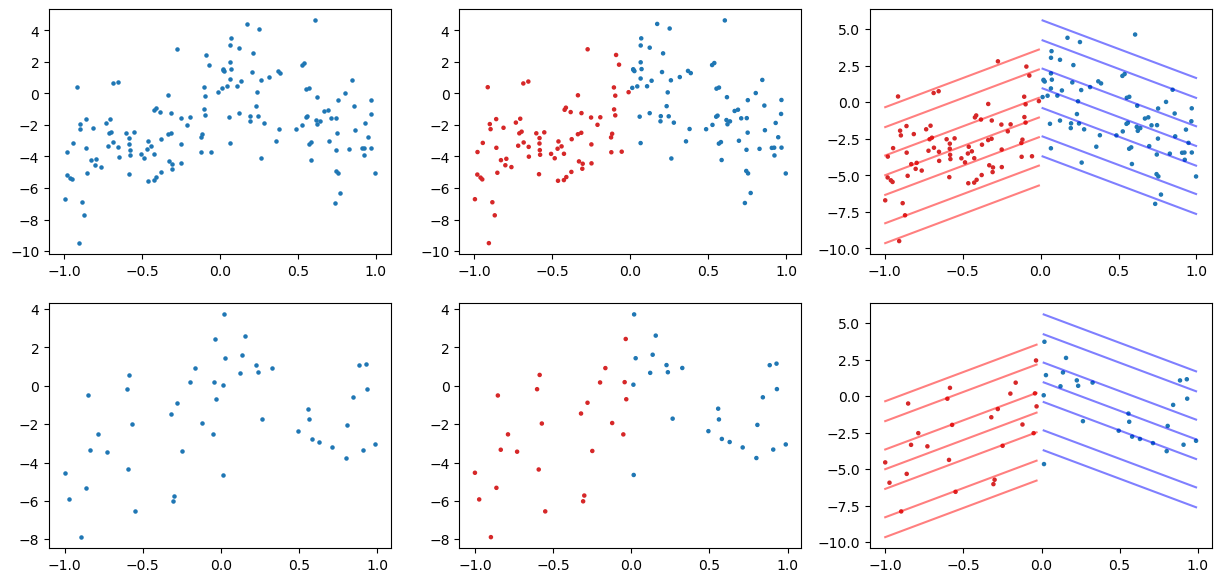

In [75]:
fig, ax = plt.subplots(2,3,figsize=(15,7))

ax[0,0].scatter(X_train,y_train, s=5)
ax[0,1].scatter(X_train,y_train,c=[col_map[i] for i in inds_train], s=5)

ax[1,0].scatter(X_test,y_test, s=5)
ax[1,1].scatter(X_test,y_test,c=[col_map[i] for i in inds_test], s=5)

col_map_true =['red','blue']
for t in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
    
    # Get implied normal quantile
    n_q = norm.ppf(t,0,2)
    
    # Get implied line
    for c in [0,1]:
        beta_c = betas[c]
        X_train_c = np.sort(X_train[inds_train==c])
        y_train_true_c = beta_c[0] + beta_c[1]*X_train_c + n_q
        
        X_test_c = np.sort(X_test[inds_test==c])
        y_test_true_c = beta_c[0] + beta_c[1]*X_test_c + n_q
    
        ax[0,2].plot(X_train_c,y_train_true_c,
                        c=col_map_true[c], alpha=0.5)
        
        ax[1,2].plot(X_test_c,y_test_true_c,
                        c=col_map_true[c], alpha=0.5)
        

ax[0,2].scatter(X_train,y_train,c=[col_map[i] for i in inds_train], s=5)
ax[1,2].scatter(X_test,y_test,c=[col_map[i] for i in inds_test], s=5)

plt.show()

# Fit EPA Model for Clustering

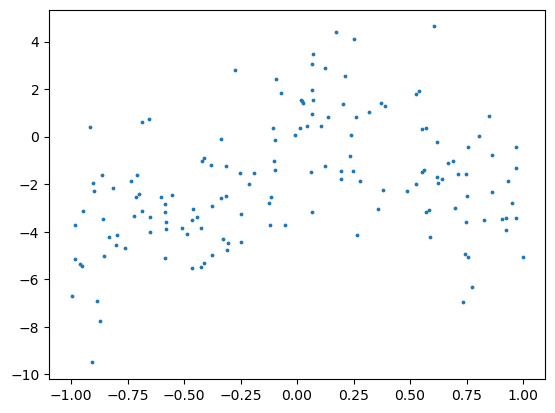

In [76]:
y_train = y_train
X_train = X_train
n_data = len(y_train)

plt.scatter(X_train,y_train, s=3)

In [77]:
from sample_processing import *
from gibbs_sampler import *

In [78]:
start_time = time.time()

# Set data
Ys = y_train
Xs = np.hstack([np.ones(len(X_train)).reshape(-1,1),X_train.reshape(-1,1)])
Zs = X_train # Set Zs as Xs

# Dist mat
tau = 2
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)

# intialize 
names_used = np.array([1,2,3])
alpha_samp = 1
partition_samp = np.random.choice(names_used,len(Xs))
partition_samp = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)
phi_samp = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 1000
k = 100 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior
alpha_init = 0.01
a_alpha = 1
b_alpha = 100
alpha_bounds = [0,1e99]

# delta prior
a_delta = 1
b_delta = 10
w = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = True
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

# phi / regression prior
phi_mean_prior = np.array([0,0])
phi_cov_prior = np.array([[10,0],[0,10]])

# regression sigma + prior hyper
sigma2_reg_init = np.array([1,1,1])
v_0 = 2
sigma2_0 = 1

partition_init = partition_samp

phi_init = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

labels_used = np.array([1,2,3])

reordering = True
use_split_merge_step = True

In [79]:
gibbs_args_single = {'Ys':Ys,
'Xs':Xs,
'Zs':Zs,
'sim_mat':sim_mat,
'partition_init':partition_init,
'phi_init':phi_init,
'phi_mean_prior':phi_mean_prior,
'phi_cov_prior':phi_cov_prior,
'sigma2_reg_init':sigma2_reg_init,
'v_0': v_0,
'sigma2_0': sigma2_0,
'tau_init':  tau_init,
'labels_used':labels_used,
'alpha_init':alpha_init,
'delta_init':delta_init,
'n_gibbs':n_gibbs,
'n_burn_in':n_burn_in,
'k':k,
'a_alpha':a_alpha,
'b_alpha':b_alpha,
'a_delta':a_delta,
'b_delta':b_delta,
'a_tau': a_tau,
'b_tau': b_tau,
'w':0.5,
'reordering':reordering,
'use_split_merge_step':use_split_merge_step,
'sample_tau':sample_tau}

In [80]:
checker1 = gibbs_sample_regression_single_thread_opt_parallel(
                               **gibbs_args_single)

Gibbs:  0  Time Taken:  3.5762786865234374e-08
Active No Clusters:  3
Gibbs:  100  Time Taken:  1.7404771486918131
Active No Clusters:  5
Gibbs:  200  Time Taken:  1.6136490821838378
Active No Clusters:  2
Gibbs:  300  Time Taken:  1.670188883940379
Active No Clusters:  4
Gibbs:  400  Time Taken:  1.6520896633466085
Active No Clusters:  2
Gibbs:  500  Time Taken:  1.5832810322443645
Active No Clusters:  4
Gibbs:  600  Time Taken:  1.8715658863385518
Active No Clusters:  2
Gibbs:  700  Time Taken:  1.586461035410563
Active No Clusters:  2
Gibbs:  800  Time Taken:  1.552241583665212
Active No Clusters:  7
Gibbs:  900  Time Taken:  1.8548928340276083
Active No Clusters:  3
Gibbs:  1000  Time Taken:  1.7034613609313964
Active No Clusters:  2
Gibbs:  1100  Time Taken:  1.4265298167864482
Active No Clusters:  2
Gibbs:  1200  Time Taken:  1.6893260677655537
Active No Clusters:  4
Gibbs:  1300  Time Taken:  1.8042118151982625
Active No Clusters:  4
Gibbs:  1400  Time Taken:  1.5878719488779705

In [ ]:
checker

In [ ]:
start = time.time()

gibbs_args_multi = {'Ys':Ys,
                    'Xs':Xs,
                    'Zs':Zs,
                    'sim_mat':sim_mat,
                    'partition_init':partition_init,
                    'phi_init':phi_init,
                    'phi_mean_prior':phi_mean_prior,
                    'phi_cov_prior':phi_cov_prior,
                    'sigma2_reg_init':sigma2_reg_init,
                    'v_0': v_0,
                    'sigma2_0': sigma2_0,
                    'tau_init':  tau_init,
                    'labels_used':labels_used,
                    'alpha_init':alpha_init,
                    'delta_init':delta_init,
                    'n_gibbs':n_gibbs,
                    'n_burn_in':n_burn_in,
                    'k':k,
                    'a_alpha':a_alpha,
                    'b_alpha':b_alpha,
                    'a_delta':a_delta,
                    'b_delta':b_delta,
                    'a_tau': a_tau,
                    'b_tau': b_tau,
                    'w':0.5,
                    'reordering':reordering,
                    'use_split_merge_step':use_split_merge_step,
                    'sample_tau':sample_tau,
                    'n_chain':2,
                    'opti':True}

mcmc_chain = gibbs_sample_regression(**gibbs_args_multi)

end = time.time()

print((end-start)/60)

### Post Processing Samples

In [ ]:
n_chains = 2

# Individual Chains
fig, ax = plt.subplots(1,2,figsize=(10,5))
chk = []
for i in range(n_chains):
    
    partition_save = mcmc_chain[i][1]
    normalized_sim_mat_part = calc_hit_matrix(partition_save,
                                         burn_samples=0,
                                         normalize=True)
    chk.append(normalized_sim_mat_part)
    ax[i].matshow(normalized_sim_mat_part)
    ax[i].set_title(f'Chain {i+1}')

In [ ]:
# Combined Chains
partition_save_combined = mcmc_chain[0][1] + mcmc_chain[1][1]

normalized_sim_mat = calc_hit_matrix(partition_save_combined,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [ ]:
col_scheme = ['tab:blue','tab:orange','tab:red','tab:green']
fig, ax = plt.subplots(2,1,figsize=(10,5))

sample_n_clusters_combined = [len(np.unique(p)) for p in partition_save_combined]

sample_n_clusters_chains = []
for i in range(n_chains):
    partition_save = mcmc_chain[i][1]
    n_clust_chain = [len(np.unique(p)) for p in partition_save]
    sample_n_clusters_chains.append(n_clust_chain)
    
    ax[0].plot(n_clust_chain,c=col_scheme[i],alpha=0.5, lw=0.5)
    ax[1].hist(n_clust_chain,color=col_scheme[i],alpha=0.5,bins=20)

    
ax[0].set_xlabel('T')
ax[0].set_ylabel('N Clust Partition')
ax[0].set_title('No Estimated Clusters')


ax[1].set_xlabel('N Clusters')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram N Clusters')
plt.tight_layout()
plt.show()

In [ ]:
print(np.mean(sample_n_clusters_combined))
print(np.mean(sample_n_clusters_chains[0]))
print(np.mean(sample_n_clusters_chains[1]))

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
linkage_type = 'average'
for i in range(n_chains):
    
    sim_mat = chk[i]
    
    agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=6,
                                       linkage_type=linkage_type)
    
    ax[i].scatter(Xs[:,1],Ys,c=[col_map[i] for i in agglo_cluster_solution],s=10)
    ax[i].set_title(f'{linkage_type} linkage - Chain {i+1}')
    
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
linkage_type = 'complete'
for i in range(n_chains):
    
    sim_mat = chk[i]
    
    agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=6,
                                       linkage_type=linkage_type)
    
    ax[i].scatter(Xs[:,1],Ys,c=[col_map[i] for i in agglo_cluster_solution],s=10)
    ax[i].set_title(f'{linkage_type} linkage - Chain {i+1}')
    
plt.show()

# Fit Base QR Model

In [8]:
y_train = y_train
X_train = X_train
n_data = len(y_train)

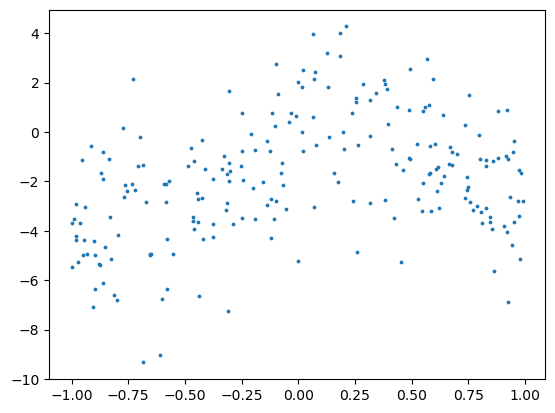

In [9]:
plt.scatter(X_train,y_train, s=3)

In [18]:
from Single_Var_QR import SingleQRSampler_T_4_block

# Choose no. of chains
n_chains = 2

# Set Grid of tau values
tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)

data_size = n_data
tau_upper_tail = 1-1/(2*data_size)
tau_lower_tail = 1/(2*data_size)
lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

# Run Sampler
sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_train,
                                    X_train,          
                                    C_1 = 0.3,
                                    lambda_step_size_1 = 3,
                                    alpha_step_size_1 = 0.4,
                                    a_target_1 = 0.228,
                                    C_2 = 0.3,
                                    lambda_step_size_2 = 3,
                                    alpha_step_size_2 = 0.4,
                                    a_target_2 = 0.228,
                                    C_3 = 0.5,
                                    lambda_step_size_3 = 3,
                                    alpha_step_size_3 = 0.4,
                                    a_target_3 = 0.228,
                                    C_4 = 0.3,
                                    lambda_step_size_4 = 3,
                                    alpha_step_size_4 = 0.4,
                                    a_target_4 = 0.228,
                                    tau_grid_expanded = tau_grid_expanded,
                                    tau_grid = tau_grid,     
                                    knot_points_grid = knot_points_grid,
                                    am_lamb_block1_init = (2.38**2)/(9),
                                    am_lamb_block2_init = (2.38**2)/(9),
                                    am_lamb_block3_init = (2.38**2)/4,
                                    am_lamb_block4_init = (2.38**2)/(9*2+4),
                                    alpha_kappa = 0.1,
                                    beta_kappa = 0.1,
                                    eps_1 = 0,
                                    eps_2 = 0,
                                    base_quantile_mean=0.0,
                                    base_quantile_sd=1.0,
                                    base_quantile_v=1,
                                    base_quantile_dist='norm',
                                    splice=True) for _ in range(n_chains)]

chain_outputs = [sampler_c.sample(n_steps=25000) for sampler_c in sampler_collecter_4blockt]

sampler_collecter = sampler_collecter_4blockt

Lambda Current:  4
Mu Current:  0
Gamma Current:  0
Sigma 1 Current:  1
Sigma 2 Current:  1
Step:  100  Time Taken:  2.118401050567627 Block 1 Accept:  33.333333333333336  Block 2 Accept:  20.0  Block 3 Accept:  0.0  Block 4 Accept:  29.166666666666668  Sampled Prop:  [0.3  0.2  0.03 0.48]
Step:  200  Time Taken:  0.5074169635772705 Block 1 Accept:  20.754716981132077  Block 2 Accept:  14.634146341463415  Block 3 Accept:  0.0  Block 4 Accept:  17.77777777777778  Sampled Prop:  [0.265 0.205 0.085 0.45 ]
Step:  300  Time Taken:  0.5386698246002197 Block 1 Accept:  21.794871794871796  Block 2 Accept:  15.254237288135593  Block 3 Accept:  0.0  Block 4 Accept:  15.942028985507246  Sampled Prop:  [0.26       0.19666667 0.08666667 0.46      ]
Step:  400  Time Taken:  0.5375301837921143 Block 1 Accept:  26.262626262626263  Block 2 Accept:  12.820512820512821  Block 3 Accept:  0.0  Block 4 Accept:  20.0  Sampled Prop:  [0.2475 0.195  0.0975 0.4625]
Step:  500  Time Taken:  0.5779919624328613 Bl

Text(0.5, 0.98, 'Posterior Estimates for Various Quantile Levels')

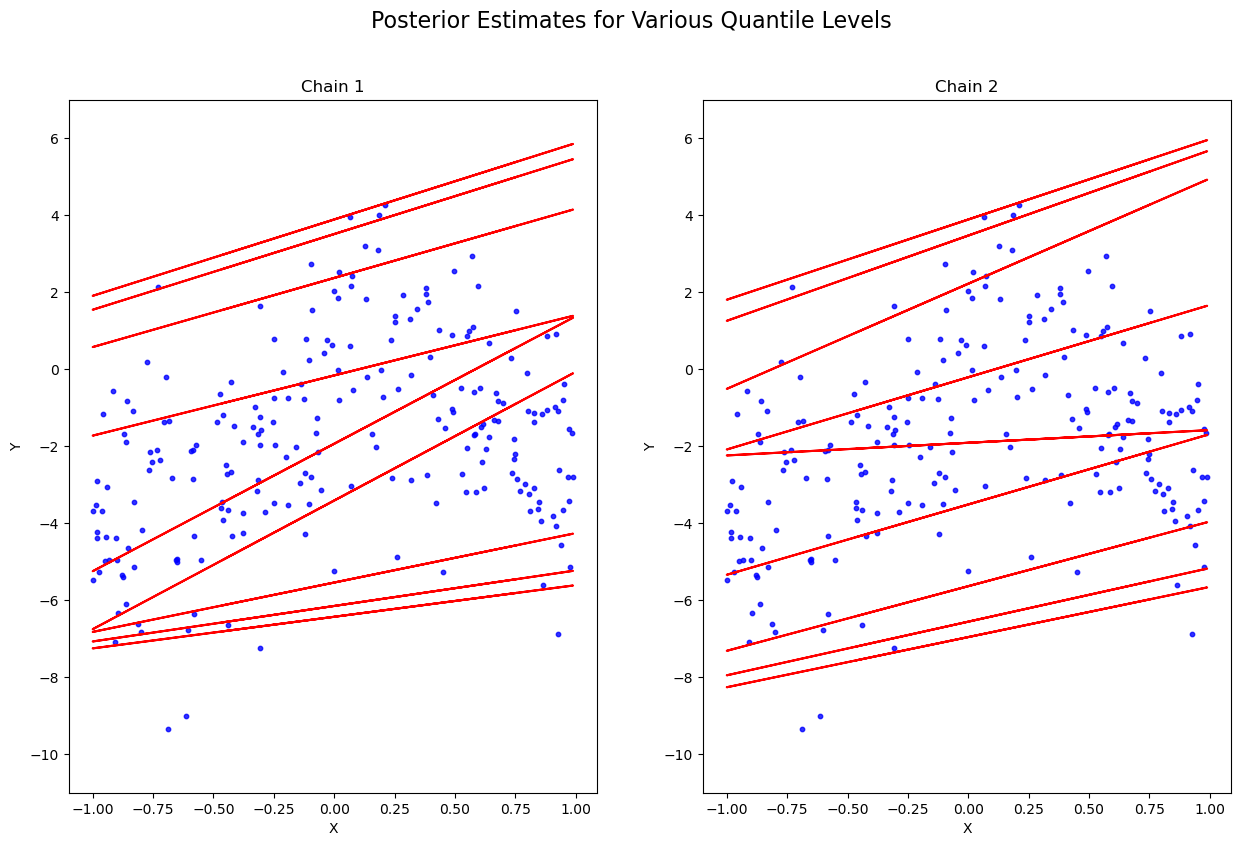

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,9))
n_burn_in = 20000

for i in range(n_chains):
    ax[i].scatter(X_train, y_train, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.00125,0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99,0.9975]
#sample_quantiles = [0.5]

for sq in sample_quantiles:
    
    for i in range(n_chains):
        beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'])

        y_pred_samples = np.array([b0 + b1*X_train for b0,b1 in zip(beta_0_samps, beta_1_samps)])
        y_pred_samples = y_pred_samples[n_burn_in:]
        
        ax[i].plot(X_train, y_pred_samples.mean(0), color='red')

for i in range(n_chains):    
    ax[i].title.set_text(f'Chain {i+1}')
        
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

#ax[0].set_ylim([-4,4])
#ax[1].set_ylim([-4,4])

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')

ax[0].set_ylim([-11,7])
ax[1].set_ylim([-11,7])

fig.suptitle('Posterior Estimates for Various Quantile Levels', fontsize=16)